# Домашнее задание: основы DL

## Задание 1

Вспомним 1ое зянятие - мы узнали, что в DL мы можем подбирать оптимальные параметры для любой дифференцируемой модели, считая градиенты по обучаемым параметрам.

В этом задании вам предстоит руками сделать backpropagation для совсем простой модели, чтобы понять, что в torch не происходит никакой магии




Пусть:

$x = [1, 1]^T$

$y = [1, -1]^T$

$z = [-1, 2]^T$


$l = sum(max(0, x*y)) + prod(x + z^2)$

где $sum, prod$ - поэлементные сложения и умножения соответственно



В ответ вам нужно указать $\frac{\partial l}{\partial x}$ и $\frac{\partial l}{\partial z}$, а в ноутбуке отобразить, как вы аналитически получили это значение

$x = [x_1, x_2]^T$

$y = [y_1, y_2]^T$

$z = [z_1, z_2]^T$

$prod(x + z^2) = (x_1 + z_1^2)(x_2 + z_2^2)$

$sum(max(0, x * y)) = max(0, x_1 * y_1) + max(0, x_2 * y_2)$

$l = max(0, x_1 * y_1) + max(0, x_2 * y_2) + (x_1 + z_1^2)(x_2 + z_2^2)$

---

$\frac{\partial l}{\partial x} = \left[ \frac{\partial l}{\partial x_1} \, \frac{\partial l}{\partial x_2} \right]$

$\frac{\partial l}{\partial x_1} = (x_1 \cdot y_1 + 0 + x_1x_2 + x_1z_2^2 + z_1^2x_2 + z_1^2z_2^2)'_{x_1} = y_1 + x_2 + z_2^2 = 1 + 1 + 4 = 6$

$\frac{\partial l}{\partial x_1} = (x_1 \cdot y_1 + 0 + x_1x_2 + x_1z_2^2 + z_1^2x_2 + z_1^2z_2^2)'_{x_2} = x_1 + z_1^2 = 1 + 1 = 2$

$\frac{\partial l}{\partial x} = \left[ \frac{\partial l}{\partial x_1} \, \frac{\partial l}{\partial x_2} \right] = [6 \, 2]$

---

$\frac{\partial l}{\partial z} = \left[ \frac{\partial l}{\partial z_1} \, \frac{\partial l}{\partial z_2} \right]$

$\frac{\partial l}{\partial z_1} = (x_1 \cdot y_1 + 0 + x_1x_2 + x_1z_2^2 + z_1^2x_2 + z_1^2z_2^2)'_{z_1} = 2 \cdot x_2 z_1 + 2 \cdot z_1 z_2^2 = 2 \cdot 1 \cdot (-1) + 2 \cdot (-1) \cdot 4 = -2 - 8 = -10$

$\frac{\partial l}{\partial z_2} = (x_1 \cdot y_1 + 0 + x_1x_2 + x_1z_2^2 + z_1^2x_2 + z_1^2z_2^2)'_{z_2} = 2 \cdot x_1 z_2 + 2 \cdot z_1^2 \cdot z_2 = 2 \cdot 1 \cdot 2 + 2 \cdot 1 \cdot 2 = 8$

$\frac{\partial l}{\partial z} = \left[ -10 \, 8 \right]$
<!-- $\frac{\partial l}{\partial z} = $ -->

Для проверки, что вы правильно поняли идею backpropagation, можете подсчитать значение $\frac{\partial l}{\partial y}$, оно должно проходить assert

In [3]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

In [5]:
dl_dy = [..., ...]
# assert np.all(dl_dy == [1, 0]), "Пока что неверное, попробуйте еще раз и все получится!"

# Задание 2

На занятиях мы часто говорили про линейные модели, что это просто. Давайте реализуем ее сами и попробуем обучать такую модель для задачи классификации (то есть реализуем логистическую регрессию)

На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта.

Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$.

Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$.

Такой класс функций называется сигмоидой. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

## Задание 2.0

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры ([`nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html)) модели. Иначе говоря здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).



In [12]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features), requires_grad=True)
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(1), requires_grad=True)

    def forward(self, x):
        res = x @ self.weights
        if self.bias:
            res += self.bias_term
        return res

### Датасет

Давайте сгенерируем датасет и посмотрим на него!

In [11]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

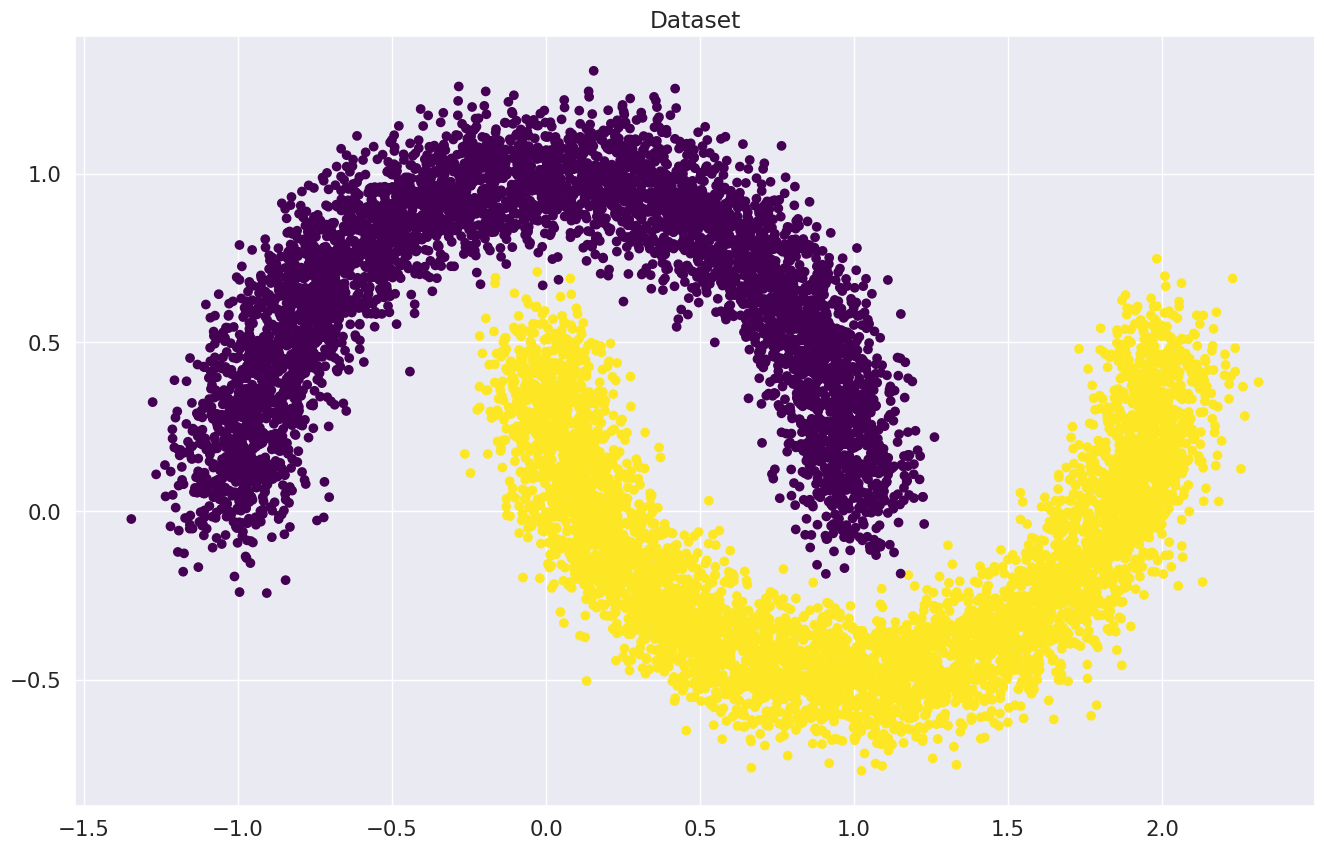

In [8]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [10]:
X_train.shape

(7500, 2)

### Загрузка данных

В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.


In [14]:
X_train_t = torch.from_numpy(X_train.astype(np.float32))
y_train_t = torch.from_numpy(y_train.astype(np.float32))
X_val_t = torch.from_numpy(X_val.astype(np.float32))
y_val_t = torch.from_numpy(y_val.astype(np.float32))

Создаем `Dataset` и `DataLoader`.

In [15]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [2]:
!pip install catalyst

^C


     ------------------------------------ 446.7/446.7 kB 321.2 kB/s eta 0:00:00
INFO: pip is looking at multiple versions of catalyst to determine which version is compatible with other requirements. This could take a while.
     ------------------------------------ 444.6/444.6 kB 250.5 kB/s eta 0:00:00
     ------------------------------------ 439.2/439.2 kB 298.3 kB/s eta 0:00:00
     ------------------------------------ 544.2/544.2 kB 319.3 kB/s eta 0:00:00
     ------------------------------------ 536.8/536.8 kB 351.0 kB/s eta 0:00:00
     ------------------------------------ 577.0/577.0 kB 335.9 kB/s eta 0:00:00
     ------------------------------------ 576.5/576.5 kB 329.6 kB/s eta 0:00:00
     ------------------------------------ 556.8/556.8 kB 380.1 kB/s eta 0:00:00
INFO: pip is still looking at multiple versions of catalyst to determine which version is compatible with other requirements. This could take a while.
     ------------------------------------ 543.2/543.2 kB 337.8 k

ERROR: Cannot install catalyst==19.10, catalyst==19.10.1, catalyst==19.10.2, catalyst==19.11, catalyst==19.11.1, catalyst==19.11.2, catalyst==19.11.3, catalyst==19.11.4, catalyst==19.11.5, catalyst==19.11.6, catalyst==19.12, catalyst==19.12.1, catalyst==19.12.2, catalyst==19.12.3, catalyst==19.3, catalyst==19.5, catalyst==19.6, catalyst==19.6.1, catalyst==19.6.2, catalyst==19.6.3, catalyst==19.6.4, catalyst==19.6.5, catalyst==19.7, catalyst==19.7.1, catalyst==19.7.2, catalyst==19.7.3, catalyst==19.7.4, catalyst==19.8, catalyst==19.8.1, catalyst==19.8.3, catalyst==19.8.4, catalyst==19.8.5, catalyst==19.8.6, catalyst==19.8.7, catalyst==19.8.8, catalyst==19.9, catalyst==19.9.1, catalyst==19.9.2, catalyst==19.9.3, catalyst==19.9.4, catalyst==19.9.5, catalyst==20.1, catalyst==20.1.1, catalyst==20.1.3, catalyst==20.10, catalyst==20.10.1, catalyst==20.11, catalyst==20.12, catalyst==20.2, catalyst==20.2.1, catalyst==20.2.2, catalyst==20.2.3, catalyst==20.2.4, catalyst==20.3, catalyst==20.3.1, 

In [7]:
from catalyst import utils

utils.set_global_seed(42)
linear_regression = LinearRegression(2, 1, True)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

ModuleNotFoundError: No module named 'catalyst'

## Задание 2.1 Сколько обучаемых параметров у получившейся модели?

Всего параметров 2 + 1 = 3


In [19]:
list(linear_regression.parameters())

[Parameter containing:
 tensor([[ 0.2303],
         [-0.4220]], requires_grad=True),
 Parameter containing:
 tensor([-1.3323], requires_grad=True)]

## Задание 2.2

Теперь обучим эту модель

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

In [20]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
prev_bias = torch.zeros_like(linear_regression.bias_term)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch)
        loss = loss_function(outp.view(-1), y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        sigm = nn.Sigmoid()
        probabilities = sigm(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        if (it + epoch*len(train_dataset)) % 500000 == 0:
            print(f"Iteration: {it + epoch*len(train_dataset)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        current_bias = linear_regression.bias_term.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol and (prev_bias - current_bias).abs().max() < tol:
            print(f"\nIteration: {it + epoch*len(train_dataset)}.\nConvergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
        prev_bias = current_bias
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.515625
Iteration: 30000
Batch accuracy: 0.7890625
Iteration: 60000
Batch accuracy: 0.8125
Iteration: 90000
Batch accuracy: 0.8203125

Iteration: 97554.
Convergence. Stopping iterations.


## Задание 2.2

Сколько итераций потребовалось, чтобы алгоритм сошелся?

105054

### Визуализируем результаты

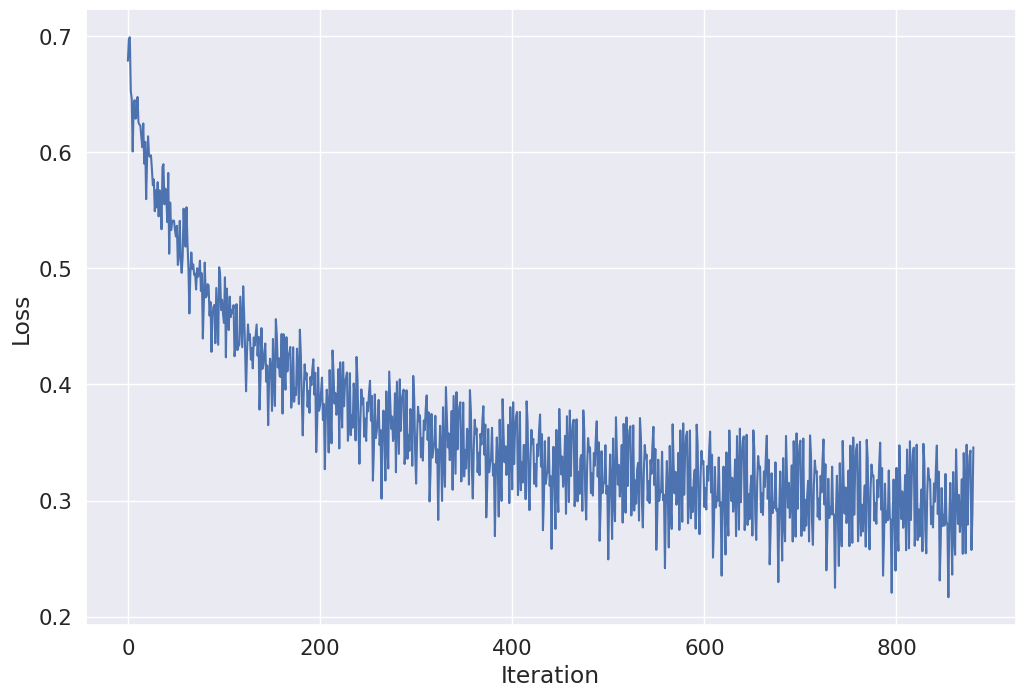

881

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()
len(losses)

In [26]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    predictions = predictions
    return predictions.flatten()

In [27]:
from sklearn.metrics import accuracy_score

out = predict(val_dataloader, linear_regression)
print(accuracy_score(out, y_val_t))

0.8688


## Задание 2.3

Какое `accuracy` получается после обучения?

0.8688


# Задание 3

Теперь перейдем к датасету MNIST!

На 2ом и 3ем семинаре мы работали с этим датасетом, поэтому ваша задача взять код от туда и исследовать такой интересный вопрос: какая функция активации лучше всего подходит под эту задачу?


Вам необходимо обучить 4 раза модель ниже и сравнить качество для различных функций активаций (или их отсутствия)

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from tqdm.notebook import tqdm

In [24]:
# используем готовый класс от торча для загрузки данных для тренировки
mnist_train = torchvision.datasets.MNIST(
    "./mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)
mnist_val = torchvision.datasets.MNIST(
    "./mnist/", train=False, download=True, transform=torchvision.transforms.ToTensor()
)

# так как это уже унаследованный от Dataset класс, его можно сразу обернуть в даталоадер
train_dataloader = torch.utils.data.DataLoader(
    mnist_train, batch_size=4, shuffle=True,
)

val_dataloader = torch.utils.data.DataLoader(
    mnist_val, batch_size=4, shuffle=False,
)

In [34]:
losses = {'no_activation': [], 'ReLU': [], 'LeakyReLU': [], 'ELU': []}
accuracies = {'no_activation': [], 'ReLU': [], 'LeakyReLU': [], 'ELU': []}

In [35]:
activation = nn.ReLU  # нужно перебрать: no_activation, ReLU, LeakyReLU, ELU

# model = nn.Sequential(
#     nn.Flatten(),
#     nn.Linear(28*28, 128),
#     activation(),
#     nn.Linear(128, 128),
#     activation(),
#     nn.Linear(128, 10)
# )

models = {}

models['no_activation'] = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.Linear(128, 128),
    nn.Linear(128, 10)
)

models['ReLU'] = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

models['LeakyReLU'] = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 10)
)

models['ELU'] = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ELU(),
    nn.Linear(128, 128),
    nn.ELU(),
    nn.Linear(128, 10)
)



max_epoch = 10

for model_name in models:
    print(model_name)
    model = models[model_name]
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
    for epoch in range(1, max_epoch + 1):
        for x_train, y_train in tqdm(train_dataloader):  # берем батч из трейн лоадера
            y_pred = model(x_train)  # делаем предсказания
            loss = F.cross_entropy(y_pred, y_train)  # считаем лосс
            loss.backward()  # считаем градиенты обратным проходом
            optimizer.step()  # обновляем параметры сети
            optimizer.zero_grad()  # обнуляем посчитанные градиенты параметров

        val_loss = []  # сюда будем складывать **средний по бачу** лосс
        val_accuracy = []
        with torch.no_grad():  # на валидации запрещаем фреймворку считать градиенты по параметрам
            for x_val, y_val in tqdm(val_dataloader):  # берем батч из валидационного лоадера
                y_pred = model(x_val)  # делаем предсказания
                loss = F.cross_entropy(y_pred, y_val)  # считаем лосс
                val_loss.append(loss.numpy())  # добавляем в массив
                val_accuracy.extend(
                    (torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist()
                )
        # печатаем метрики
        print(
            f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}"
        )
        losses[model_name].append(np.mean(val_loss))
        accuracies[model_name].append(np.mean(val_accuracy))


no_activation


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 1, loss: 0.4339997470378876, accuracy: 0.8777


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 2, loss: 0.39475783705711365, accuracy: 0.8888


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 3, loss: 0.44390782713890076, accuracy: 0.8732


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 4, loss: 0.44515708088874817, accuracy: 0.8721


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 5, loss: 0.6191442608833313, accuracy: 0.8358


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 6, loss: 0.46209657192230225, accuracy: 0.8641


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 7, loss: 0.4617071747779846, accuracy: 0.8747


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 8, loss: 0.37206095457077026, accuracy: 0.8957


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 9, loss: 0.48067402839660645, accuracy: 0.859


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 10, loss: 0.43436723947525024, accuracy: 0.8692
ReLU


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 1, loss: 0.11039930582046509, accuracy: 0.9637


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 2, loss: 0.08316753804683685, accuracy: 0.9739


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 3, loss: 0.10554628819227219, accuracy: 0.9677


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 4, loss: 0.08885473757982254, accuracy: 0.9746


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 5, loss: 0.12628933787345886, accuracy: 0.964


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 6, loss: 0.09032736718654633, accuracy: 0.977


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 7, loss: 0.09297832101583481, accuracy: 0.9747


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 8, loss: 0.10951381921768188, accuracy: 0.9731


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 9, loss: 0.11364755779504776, accuracy: 0.9749


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 10, loss: 0.11802860349416733, accuracy: 0.9726
LeakyReLU


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 1, loss: 0.16961146891117096, accuracy: 0.9476


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 2, loss: 0.110744409263134, accuracy: 0.9655


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 3, loss: 0.08836057037115097, accuracy: 0.974


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 4, loss: 0.08543079346418381, accuracy: 0.9739


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 5, loss: 0.0822749137878418, accuracy: 0.9754


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 6, loss: 0.07462706416845322, accuracy: 0.9781


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 7, loss: 0.09868700057268143, accuracy: 0.9746


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 8, loss: 0.11174102872610092, accuracy: 0.9722


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 9, loss: 0.11428200453519821, accuracy: 0.9757


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 10, loss: 0.09379025548696518, accuracy: 0.9796
ELU


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 1, loss: 0.16280627250671387, accuracy: 0.9463


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 2, loss: 0.11069928854703903, accuracy: 0.9662


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 3, loss: 0.10731782019138336, accuracy: 0.9672


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 4, loss: 0.10012052953243256, accuracy: 0.9729


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 5, loss: 0.11314577609300613, accuracy: 0.9689


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 6, loss: 0.10815627127885818, accuracy: 0.9708


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 7, loss: 0.121498242020607, accuracy: 0.9697


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 8, loss: 0.12027478218078613, accuracy: 0.9721


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 9, loss: 0.11612972617149353, accuracy: 0.9738


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 10, loss: 0.10444865375757217, accuracy: 0.976


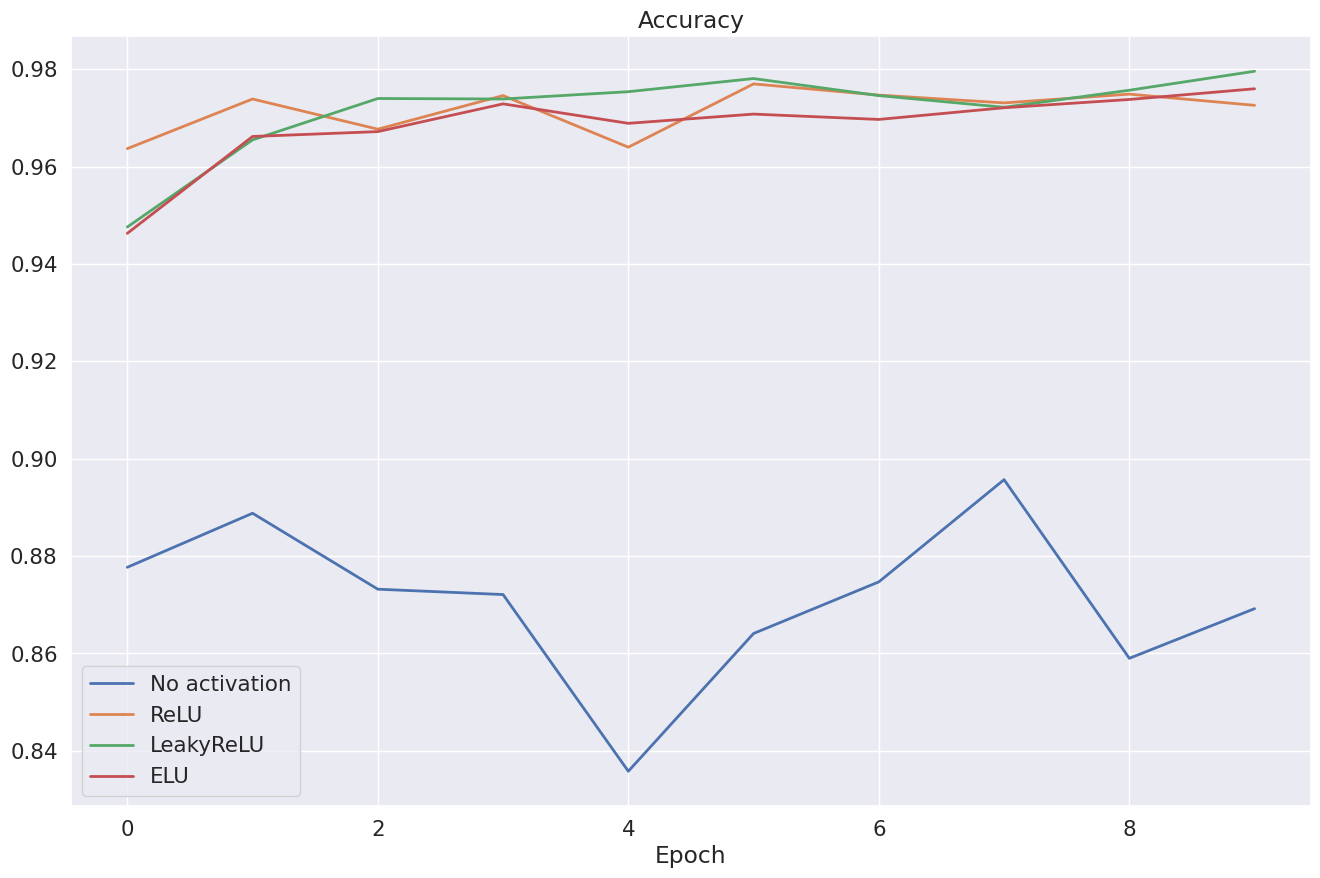

In [36]:
plt.figure(figsize=(16, 10))
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.plot(range(max_epoch), accuracies['no_activation'], label="No activation", linewidth=2)
plt.plot(range(max_epoch), accuracies['ReLU'], label="ReLU", linewidth=2)
plt.plot(range(max_epoch), accuracies['LeakyReLU'], label="LeakyReLU", linewidth=2)
plt.plot(range(max_epoch), accuracies['ELU'], label="ELU", linewidth=2)
plt.legend()
plt.show()


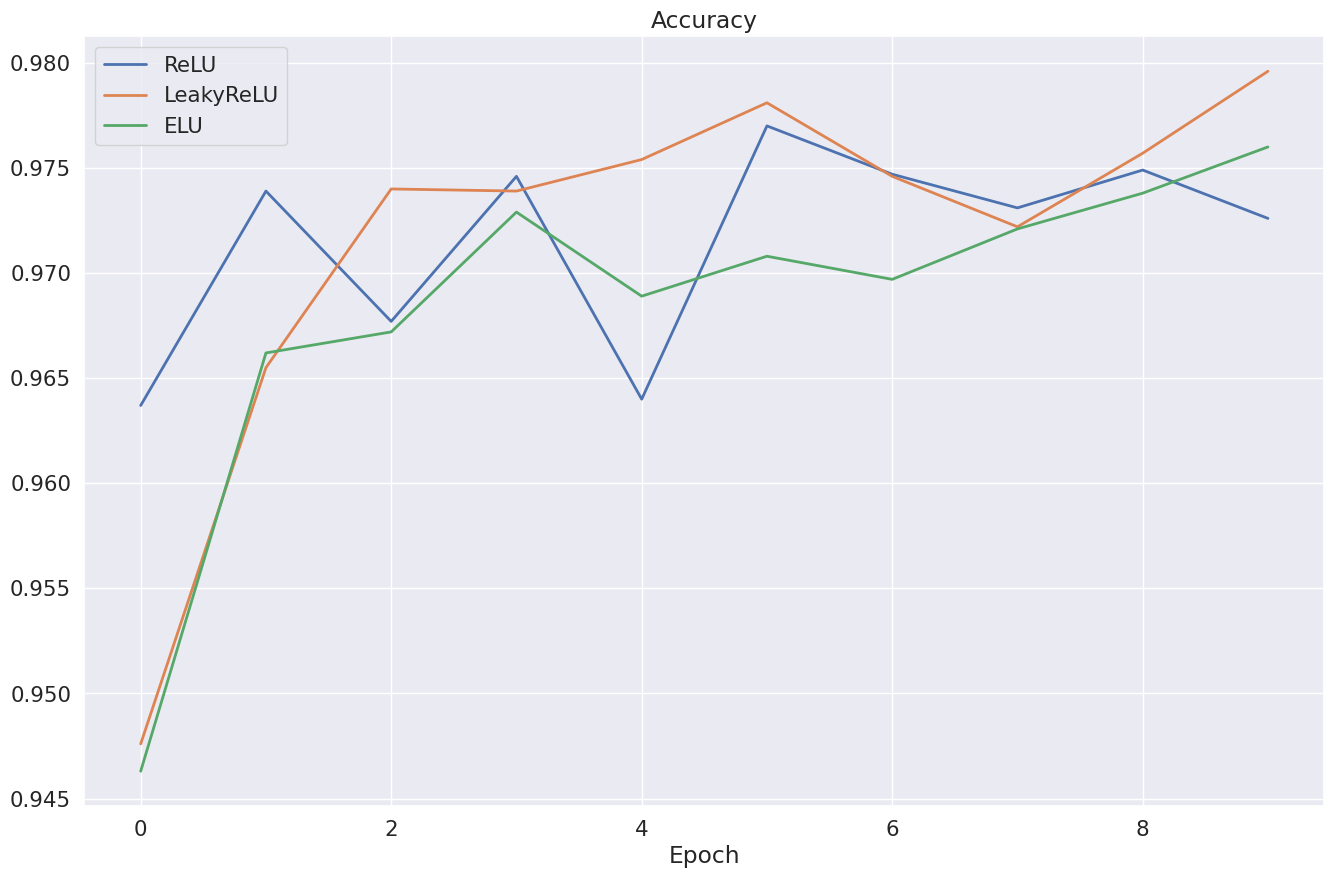

In [37]:
plt.figure(figsize=(16, 10))
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.plot(range(max_epoch), accuracies['ReLU'], label="ReLU", linewidth=2)
plt.plot(range(max_epoch), accuracies['LeakyReLU'], label="LeakyReLU", linewidth=2)
plt.plot(range(max_epoch), accuracies['ELU'], label="ELU", linewidth=2)
plt.legend()
plt.show()

Необходимо построить график: valid accuracy от номера эпохи (максимум 10 эпох) для разных функций активации и выбрать лучшую из них

**Вопрос 3** Какая из активаций показала наивысший `accuracy`?

Все функции активации показывают схожие результаты, но у LeakyReLU все же в среднем результат лучше

**Ответ: LeakyReLU**

# Задание 4

Теперь обучим архитектуру, которая использует операции nn.Conv2d. На семинарах мы наблюдали, что можем сильно увеличить качество решения.

Давайте посмотрим на архитектуру, предложенную еще в 1998 году - [LeNet](https://en.wikipedia.org/wiki/LeNet)!

In [38]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(25 * 16, 120)  # YOUR CODE HERE
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3)) # YOUR CODE HERE
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": val_dataloader}

In [40]:
max_epochs = 10


accuracies['LeNet'] = []
losses['LeNet'] = []

for epoch in range(max_epochs):
    # тренировка
    for x_train, y_train in tqdm(train_dataloader):
        y_pred = model(x_train)
        loss = F.cross_entropy(y_pred, y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # валидация
    val_loss = []
    val_accuracy = []
    with torch.no_grad():
        for x_val, y_val in tqdm(val_dataloader):
            y_pred = model(x_val)
            loss = F.cross_entropy(y_pred, y_val)
            val_loss.append(loss.numpy())
            val_accuracy.extend(
                (torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist()
            )

    # печатаем метрики
    print(
        f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}"
    )
    losses['LeNet'].append(np.mean(val_loss))
    accuracies['LeNet'].append(np.mean(val_accuracy))


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 0, loss: 0.07249249517917633, accuracy: 0.9769


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 1, loss: 0.04841389134526253, accuracy: 0.9848


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 2, loss: 0.0557076595723629, accuracy: 0.9824


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 3, loss: 0.04248065501451492, accuracy: 0.9873


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 4, loss: 0.04864378273487091, accuracy: 0.9861


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 5, loss: 0.0661005973815918, accuracy: 0.9824


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 6, loss: 0.04833073541522026, accuracy: 0.9873


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 7, loss: 0.06286507844924927, accuracy: 0.9853


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 8, loss: 0.05126558989286423, accuracy: 0.9877


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 9, loss: 0.04665125533938408, accuracy: 0.9895


Необходимо обучить модель и сравнить дают ли сверточные слои прирост к качеству? Для этого ответить на вопрос

Да, дают большой прирост

## Задание 4
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ: 0,99**